In [1]:
!pip install langgraph langchain-openai langchain-google pydantic python-dotenv langgraph langchain_google_genai

In [2]:
class Person:
  name = "Nachiketh"
  age = 33

p = Person()
print(p.name)

Nachiketh


In [3]:
getattr(p, "name")

'Nachiketh'

In [4]:
p.designation

AttributeError: 'Person' object has no attribute 'designation'

In [7]:
getattr(p, "designation","not_available") # default value

'not_available'

In [8]:
# use case
# calculator  & string manipulator tool (reverse the string)
# abc --> cba


# Use Case
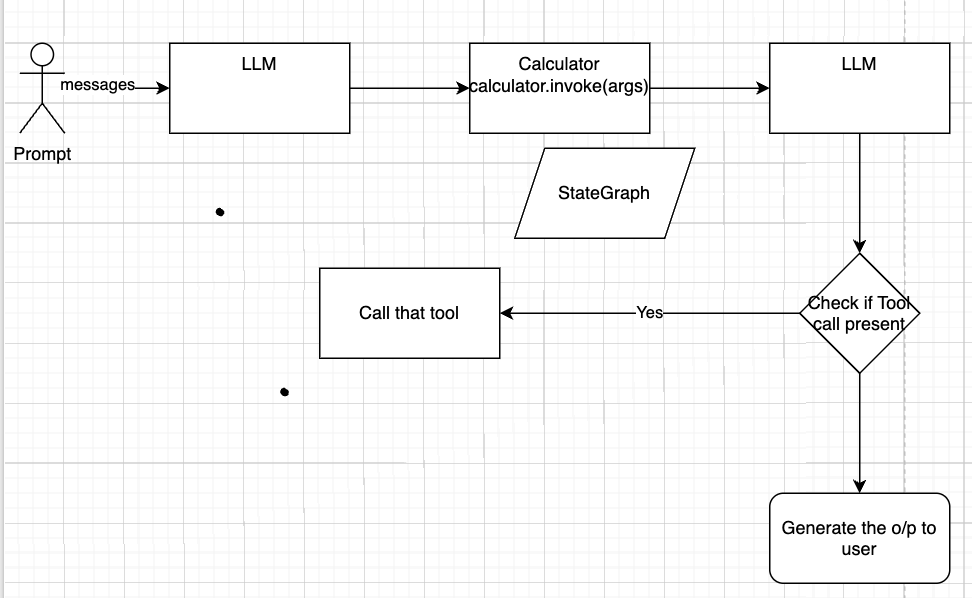

In [ ]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage,AIMessage, ToolMessage, BaseMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
import numexpr
google_api_key = "your-api-key-here"

In [10]:
@tool
def calculator(query: str) -> str:
  """
  A simple calculator toool, Input should be mathematical expression
  """
  return str(numexpr.evaluate(query))

In [11]:
calculator.invoke({"query": "6+25"})

'31'

In [12]:
calculator.invoke({'query': '100000 * 0.065 * 1'})

'6500.0'

In [15]:
@tool
def reverse_string(query: str) -> str:
  """
  Reverse the input text
  """
  return query[::-1]

In [16]:
s = "hello"
s[::-1]

'olleh'

In [17]:
reverse_string.invoke({"query": "hello"})

'olleh'

In [ ]:
@tool
def fetch_document_from_s3(object_name: str) -> str:
  """
  This is a function that fetches the document from s3 bucket
  """
  # code that will fetch the record from pre-defined s3 bucket
  # return the file
  pass

In [18]:
TOOLS = {"calculator": calculator, "reverse_string": reverse_string}

In [47]:
class AgentState(TypedDict):
  input: str
  messages: List[BaseMessage]

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                             temperature=0.5,
                             google_api_key=google_api_key).bind_tools(list(TOOLS.values()))

MAX_STEPS = 3

In [57]:
def agent_loop(state: AgentState) -> AgentState:
  msgs = list(state.get("messages",[]))
  if state.get("input"):
    msgs.append(HumanMessage(content=state["input"]))

  for step in range(MAX_STEPS):
    ai = llm.invoke(msgs) # ask model
    msgs.append(ai)

    calls = getattr(ai,"tool_calls", None)
    if not calls:
      print(f"final output is {ai.content}")
      return {"messages": msgs}

    call = calls[-1] # extract the latest tool call
    name = call.get("name")
    args = call.get("args")
    tool_fn = TOOLS.get(name) # if any error


    result = tool_fn.invoke(args)
    msgs.append(ToolMessage(tool_call_id=call.get("id"),
                            content=result))

  return {"messages": msgs}

In [77]:
builder = StateGraph(AgentState)
builder.add_node("agent",agent_loop)
builder.add_edge(START,"agent")
builder.add_edge("agent",END)
app = builder.compile(checkpointer = MemorySaver())

out = app.invoke({"input": "calculate 14+25 ?"}, config={"configurable":
                                                      {"thread_id": "u1"}})


final output is The answer is 39.


In [78]:
ai_message = [msg.content for msg in out["messages"] if isinstance(msg, AIMessage)]

In [79]:
ai_message.reverse()
ai_message[0]

'The answer is 39.'

In [86]:

app = builder.compile(checkpointer = MemorySaver())
out = app.invoke({"input": "reverse the word - hello"}, config={"configurable":
                                                      {"thread_id": "u1x"}})
ai_message = [msg.content for msg in out["messages"] if isinstance(msg, AIMessage)]
ai_message.reverse()
ai_message[0]

final output is The reversed word is "olleh".


'The reversed word is "olleh".'

In [81]:
out

{'input': 'reverse the word - hello',
 'messages': [HumanMessage(content='calculate 14+25 ?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'calculator', 'arguments': '{"query": "14+25"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--aaf94fca-17c6-479e-8b6d-2af03c16dc54-0', tool_calls=[{'name': 'calculator', 'args': {'query': '14+25'}, 'id': '8cdc075c-2078-4e13-bb5f-2bc44d007855', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 71, 'total_tokens': 157, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 54}}),
  ToolMessage(content='39', tool_call_id='8cdc075c-2078-4e13-bb5f-2bc44d007855'),
  AIMessage(content='The answer is 39.', additional_kwargs={}, response_metadata={'pro